### 1) Imports

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

sys.path.append('../../../utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
from coordinatesConversions import *
from cmpt_TuneSpreads import *

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

PyHEADTAIL v1.13.5


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
plt.close('all')
plane_of_study = 'y'

### 2) Variables we change

In [4]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(1000)#int(1e5)            #number of cycles to run the simulation for
decTurns = 1#int(100)               #how often to record data

Q_y = 26.18                #How many times the particles oscillate in phase space each turn 
Q_x = 26.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

ampGain = 0               #strength of amplitude feedback (usually between 0 and 0.15)
phaseGain = 0             #strength of phase feedback (usually between 0 and 0.15)

filename = 'file.txt'      #Where the data for the run is saved

numDelay = 1                #Turns of delay between measuring and acting with the feedback system
                            #Make sure to adjust Q_x if adjusting numDelay

ampNoiseOn = 0              #Turns on the amplitude noise - 0 is off, 1 is on
phaseNoiseOn = 0            #Turns on the phase noise - 0 is off, 1 is on
stdAmpNoise = 1e-8          #Size of amplitude noise (1e-8 for ~22nm/s at 0 ampGain)
stdPhaseNoise = 1e-8      #Size of phase noise (1e-8 for ~24nm/s at 0 phaseGain)

damperOn = 0                #Turns on the damper - 0 is off, 1 is on
dampingrate_x = 50          #Strength of the damper (note it must be turned on further down in the code) 
                            #(40 is the "standard" value)

measNoiseOn = 0             #Turns on the measurement noise - 0 is off, 1 is on
stdMeasNoise = 1000e-9       #standard deviation of measurement noise

### 3) Variables we don't change

In [5]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 1
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)

Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0, 0 #10

# detuning coefficients in (1/m)
app_x = 0.0  #2.4705e-15 #4e-11
app_xy = 0.0 #-0*2.25e-11
app_y = 15000  #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)

# CREATE DAMPER
# =============
dampingrate_y = 10 #40
damper = TransverseDamper(dampingrate_x, dampingrate_y)

# CREATE BEAM
# ===========
macroparticlenumber = 1000

charge = e
mass = m_p
intensity = 3.5e10

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6
    
epsn_z    = 2.5
sigma_z   = 0.155 #2*0.0755

sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

bunch = generate_Gaussian6DTwiss(
    macroparticlenumber, intensity, charge, mass, circumference, gamma,
    alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)
xoffset = 0e-4
yoffset = 0e-4
bunch.x += xoffset
bunch.y += yoffset


afile = open('bunch', 'wb')
pickle.dump(bunch, afile)
afile.close()

Dampers active


### 4) Create transverse and longitudinal map

In [6]:
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

### 5) Set up the acclerator

In [8]:
if ampNoiseOn == 1:
    ampKicks = np.random.normal(0, stdAmpNoise, n_turns)
else:
    ampKicks = np.zeros(n_turns)
if phaseNoiseOn == 1:
    phaseKicks = np.random.normal(0, stdPhaseNoise, n_turns)
else:
    phaseKicks = np.zeros(n_turns)
if measNoiseOn == 1:
    noise = np.random.normal(0, stdMeasNoise, n_turns)# / beta_x[0] #Remove beta_x[0] when measuring in x
else:
    noise = np.zeros(n_turns)

delayAmp = np.zeros(numDelay + 1)
delayPhase = np.zeros(numDelay + 1)

t0 = time.clock()

#reload object from file
file2 = open('bunch', 'rb')
bunch = pickle.load(file2)
file2.close()

one_turn_map = []
for i, segment in enumerate(transverse_map):
    one_turn_map.append(segment)
    #if wakefieldOn:
    #    if i+1 == i_wake:
    #        one_turn_map.append(wake_field_kicker)
one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


### 6) Start tracking

In [9]:
meanX = np.zeros(n_damped_turns)
meanY = np.zeros(n_damped_turns)
meanXsq = np.zeros(n_damped_turns)
meanYsq = np.zeros(n_damped_turns)
emitX = np.zeros(n_damped_turns)
emitY = np.zeros(n_damped_turns)

for i in range(n_turns):
    
    # Crab cavity
    Vcc = 1e6
    p_cc = Vcc/(gamma*.938e9)  # Vo/Eb
    #bunch.xp += (i/n_turns)*p_cc*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)  

    # Gaussian Amplitude noise
    #bunch.xp += ampKicks[i]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    bunch.yp += ampKicks[i]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    # Gaussian Phase noise
    #bunch.xp += phaseKicks[i]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    bunch.yp += phaseKicks[i]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    #These next two lines actually "run" the simulation - the computationally heavy part
    for m in one_turn_map:
        m.track(bunch)
        
    negavg = np.mean(bunch.x[bunch.z < 0.0])
    posavg = np.mean(bunch.x[bunch.z > 0.0])
        
    #Amplitude Correction
    posCorr = (posavg-negavg)/2
    posCorr = posCorr + noise[i]
    momCorr = (ampGain)*posCorr/beta_x[0]
    delayAmp[0:-1] = delayAmp[1:]
    delayAmp[numDelay] = momCorr
    #bunch.xp += delayAmp[0]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    
    #Phase Correction
    posCorr = (posavg+negavg)/2
    posCorr = posCorr + noise[i]
    momCorr = (phaseGain)*posCorr/beta_x[0]
    delayPhase[0:-1] = delayPhase[1:]
    delayPhase[numDelay] = momCorr
    #bunch.xp += delayPhase[0]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    if i%decTurns is  0:
        j = int(i/decTurns)
        meanX[j] = np.mean(bunch.x)
        meanY[j] = np.mean(bunch.y)
        meanXsq[j] = np.mean((bunch.x-np.mean(bunch.x))**2)
        meanYsq[j] = np.mean((bunch.y-np.mean(bunch.y))**2)
        emitX[j] = bunch.epsn_x()
        emitY[j] = bunch.epsn_y()


dataExport = [meanX, meanY, meanXsq, meanYsq, emitX, emitY]

f = open(filename, 'w')

with f:
    out = csv.writer(f, delimiter=',')
    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: " + str(time.clock() - t0))



--> Done.
Simulation time in seconds: 0.04095499999999985


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
# Load the file with all of the saved data from the run
meanX, meanY, meanXsq, meanYsq, emitX, emitY = np.loadtxt(filename, delimiter = ",", unpack = True)

# Calculate the Emittance Growth Rate (EGR) in nm/s
separationTime = 1 / frev * decTurns #There are decTurns revolutions before each recording of data
tspan          = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation
growthTotal = np.polyfit(tspan[2:], emitX[1:-1], 1)[0] #Fits a degree 1 polynomial to the graph of emittance over time and gets the slope
print("Emmittance growth rate = " + str(growthTotal*10**9) + " nm/s")

Emmittance growth rate = -5011.319154183962 nm/s


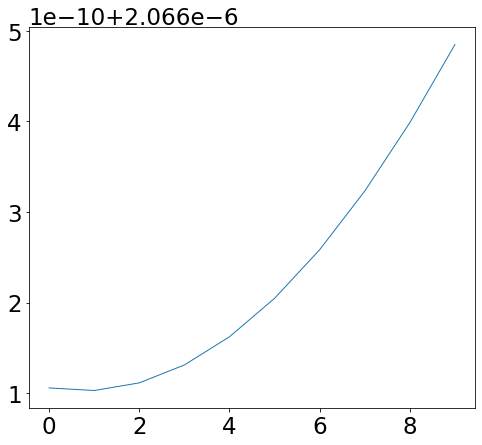

In [11]:
plt.plot(emitY)